# Домашнее задание 2. Работа с изображениями

В этом задании предлагается решить простейшую задачу рапознавания лиц. Вам нужно будет научить модель для пары картинок определять, разные ли люди на них изображены.

Работать будем с датасетом фотографий известных людей. Скачать его можно [тут](https://disk.360.yandex.ru/d/oAmJgPESjP33hg). В нём представлены 150 человек, для каждого по 6-9 фотографий. Всего около 1000 изображений.

__Задание__. Вам потребуется выполнить два задания:

1) Реализовать модель бинарной классификации и добиться приемлемого качества.

2) Реализовать триплетную функцию потерь и улучшить качество предсказаний с ее помощью.

Напишите краткий отчёт о проделанных экспериментах. Что сработало и что не сработало? Почему вы решили, сделать так, а не иначе? Обязательно указывайте ссылки на чужой код, если вы его используете. Обязательно ссылайтесь на статьи / блогпосты / вопросы на stackoverflow / видосы от ютуберов-машинлернеров / курсы / подсказки от Дяди Васи и прочие дополнительные материалы, если вы их используете.

__Во всех заданиях будем придерживаться следующих правил__:
1. Использовать внешние данные для обучения строго запрещено. Также запрещено обучаться на валидационной выборке.
2. Все задания должны быть выполнены без использования предобученных моделей и готовых реализаций. Тем не менее:
    - В заданиях, где требуется достичь некоторого качества модели, разрешается использовать предобученные модели. Но __оценка за задние будет снижена__ (для каждого задания будет отдельно указано, на сколько).
    - В некоторых заданиях может сильно помочь библотека [pytorch-metric-learning](https://kevinmusgrave.github.io/pytorch-metric-learning/). Вы можете использовать готовые реализации из неё, но __максимальный балл за задание также будет снижен__.

__Советы и указания__:
 - Наверняка вам потребуется много гуглить о том, как заставить это всё работать. Это нормально, все гуглят. Но не забывайте, что нужно быть готовым за скатанный код отвечать :)
 - Рекомендуем использовать шаблоны ниже. Однако делать это мы не заставляем. Если вам так неудобно, то можете писать код в удобном стиле. Однако учтите, что чрезмерное изменение нижеперечисленных шаблонов увеличит количество вопросов к вашему коду :)
 - Валидируйте. Трекайте ошибки как можно раньше, чтобы не тратить время впустую.
 - Чтобы быстро отладить код, пробуйте обучаться на маленькой части датасета (скажем, 5-10 картинок просто чтобы убедиться что код запускается). Когда вы поняли, что смогли всё отдебажить, переходите обучению по всему датасету
 - На каждый запуск делайте ровно одно изменение в модели/аугментации/оптимайзере, чтобы понять, что и как влияет на результат.
 - Фиксируйте random seed.
 - Правильно нормализуйте данные при создании, пример [тык, но тут и в целом гайд от и до](https://www.pluralsight.com/guides/image-classification-with-pytorch)
 - Начинайте с простых моделей и постепенно переходите к сложным. Обучение лёгких моделей экономит много времени. Можно написать свою модель руками, а можно импортировать не предобученную сетку известной архитектуры из модуля `torchvision.models`. Один из способов как можно сделать: [документация (полезная)](https://pytorch.org/vision/stable/models.html)
 - Используйте все возможные методы оптимизации и эксперемнтируйте с ними.
 - Ставьте расписание на learning rate. Уменьшайте его, когда лосс на валидации перестаёт убывать.
 - Model Checkpointing. Сохраняйте свой прогресс (модели), чтобы когда что-то пойдет не так вы сможете начать с этого места или просто воспроизвести свои результаты модели, которые обучали.
    * Пример как можно с wandb тут: [Сохраняем лучшие модели в wandb](https://docs.wandb.ai/guides/integrations/lightning)
    * По простому можно так: [Сохраняем модели в pytorch дока](https://pytorch.org/tutorials/beginner/saving_loading_models.html)
 - Советуем использовать GPU. Если у вас его нет, используйте google colab. Если вам неудобно его использовать на постоянной основе, напишите и отладьте весь код локально на CPU, а затем запустите уже написанный ноутбук в колабе.

Good luck & have fun! :)

In [1]:
import os

import numpy as np
import tqdm
import numpy
import torch
import pandas
import random
import torchvision
import sklearn.metrics
import torch.utils.data
import matplotlib.pyplot as plt
import torchvision.transforms.v2 as transforms_v2

In [2]:
# Можно использовать, но балл за соответствующие задания будет снижен.
# import pytorch_metric_learning.distances
# import pytorch_metric_learning.samplers
# import pytorch_metric_learning.losses

In [3]:
# Обязательно вызывайте эту функцию перед каждый запуском обучения!
# Если проверяющий не сможет воспроизвести результат, оценка за задание будет снижена.
def set_random_seed(seed: int = 42):
    random.seed(seed)
    numpy.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.backends.cudnn.deterministic = True

set_random_seed()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### [1.5 балла] Часть 1. Подготовка данных.

##### [0.5 балла] Задание 1.1. Считать датасет.

Сначала нужно считать датасет с фотографиями и посмотреть на его устройство.

In [4]:
# https://www.binarystudy.com/2022/04/how-to-normalize-image-dataset-inpytorch.html

def batch_mean_and_sd(loader):

    cnt = 0
    fst_moment = torch.empty(3)
    snd_moment = torch.empty(3)

    for images, _ in loader:
        b, c, h, w = images.shape
        nb_pixels = b * h * w
        sum_ = torch.sum(images, dim=[0, 2, 3])
        sum_of_square = torch.sum(images ** 2,
                                  dim=[0, 2, 3])
        fst_moment = (cnt * fst_moment + sum_) / (
                      cnt + nb_pixels)
        snd_moment = (cnt * snd_moment + sum_of_square) / (
                            cnt + nb_pixels)
        cnt += nb_pixels

    mean, std = fst_moment, torch.sqrt(
      snd_moment - fst_moment ** 2)
    return mean,std


# Перед тем, как узнать наше распределение, нужно сделать тестовый простой лоадер
transform_1 = transforms_v2.Compose([
    transforms_v2.Resize((250, 250)),
    transforms_v2.ToTensor()
])

dataset_1 = torchvision.datasets.ImageFolder("data/training", transform = transform_1)
loader_1 = torch.utils.data.DataLoader(dataset_1, batch_size=64, shuffle=False)
# Теперь применяем нашу чудо функцию для среднего и дисперсии
mean_ds1, std_ds1 = batch_mean_and_sd(loader_1)

transform_2 = transforms_v2.Compose([
    transforms_v2.Resize((250, 250)),
    transforms_v2.CenterCrop((250, 250)),
    transforms_v2.ToTensor(),
    transforms_v2.Normalize(mean_ds1, std_ds1)
])

train_ds = torchvision.datasets.ImageFolder("data/training", transform = transform_2)
test_ds = torchvision.datasets.ImageFolder("data/testing", transform = transform_2)

C:\Users\Dmitriy\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\transforms\v2\_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


Давайте посмотрим на примеры фотографий. Нарисуйте несколько.

tensor([[[0.1294, 0.1333, 0.1412],
         [0.1255, 0.1412, 0.1451],
         [0.1294, 0.1451, 0.1490],
         ...,
         [0.0784, 0.0784, 0.0863],
         [0.0745, 0.0784, 0.0941],
         [0.0745, 0.0784, 0.0941]],

        [[0.1333, 0.1373, 0.1451],
         [0.1255, 0.1412, 0.1451],
         [0.1255, 0.1490, 0.1490],
         ...,
         [0.0784, 0.0784, 0.0863],
         [0.0745, 0.0784, 0.0941],
         [0.0745, 0.0784, 0.0941]],

        [[0.1294, 0.1451, 0.1490],
         [0.1294, 0.1451, 0.1490],
         [0.1294, 0.1529, 0.1529],
         ...,
         [0.0784, 0.0784, 0.0863],
         [0.0745, 0.0784, 0.0941],
         [0.0745, 0.0784, 0.0941]],

        ...,

        [[0.8510, 0.8667, 0.8784],
         [0.8314, 0.8471, 0.8588],
         [0.8392, 0.8549, 0.8667],
         ...,
         [0.8157, 0.8039, 0.7843],
         [0.7765, 0.7569, 0.7333],
         [0.7373, 0.7176, 0.6941]],

        [[0.8549, 0.8706, 0.8824],
         [0.8353, 0.8510, 0.8627],
         [0.

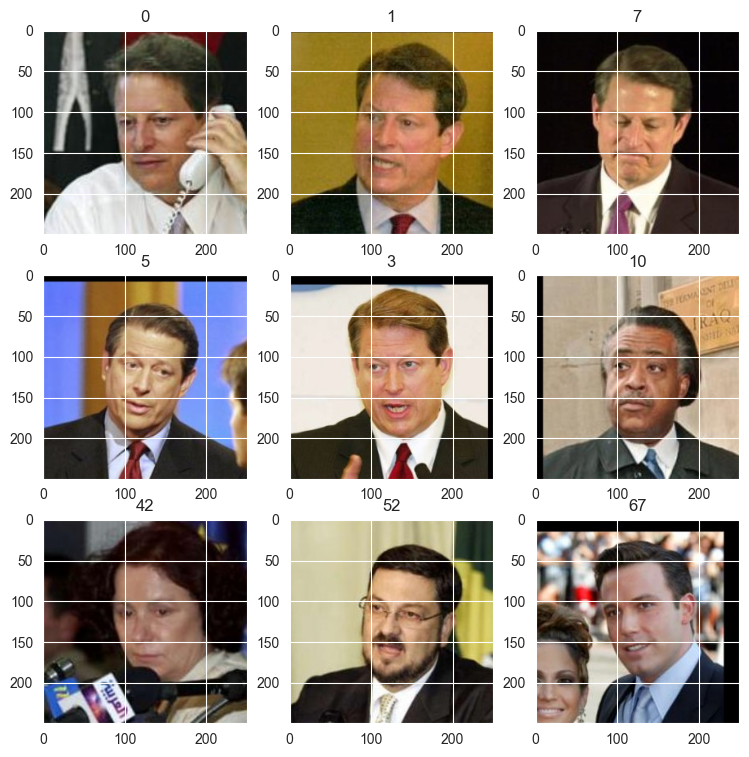

In [5]:
# Если знаешь, что означают все эти странные числа и почему они именно такие - мы одного поля ягоды

images_idx = [0, 1, 7, 1337 // 228, 89 // 27, 2004 // 192, 42, 52, 67]

def denormalize_image(img, std_was, mean_was):
    return img.clone() * std_was + mean_was

# 3x3 сетка, 9 изображений
fig, axs = plt.subplots(3, 3, figsize=(9, 9))

for image_idx, ax in zip(images_idx, axs.flat):
    # В train_ds у нас раздельно хранятся каналы как 3 разных изображения, надо слить их в пиксели. Перемешаем оси, чтобы не делать это вручную
    print(denormalize_image(train_ds[image_idx][0].permute(1, 2, 0), std_ds1, mean_ds1))  # https://www.pythontutorials.net/blog/numpy-permute/
    im = ax.imshow(denormalize_image(train_ds[image_idx][0].permute(1, 2, 0), std_ds1, mean_ds1).numpy())
    ax.set_title(str(image_idx))
    
plt.show()

Наконец, следует вывести распределение фотографий по людям и убедиться, что для каждого человека действительно предствалено 6-9 фотографий.

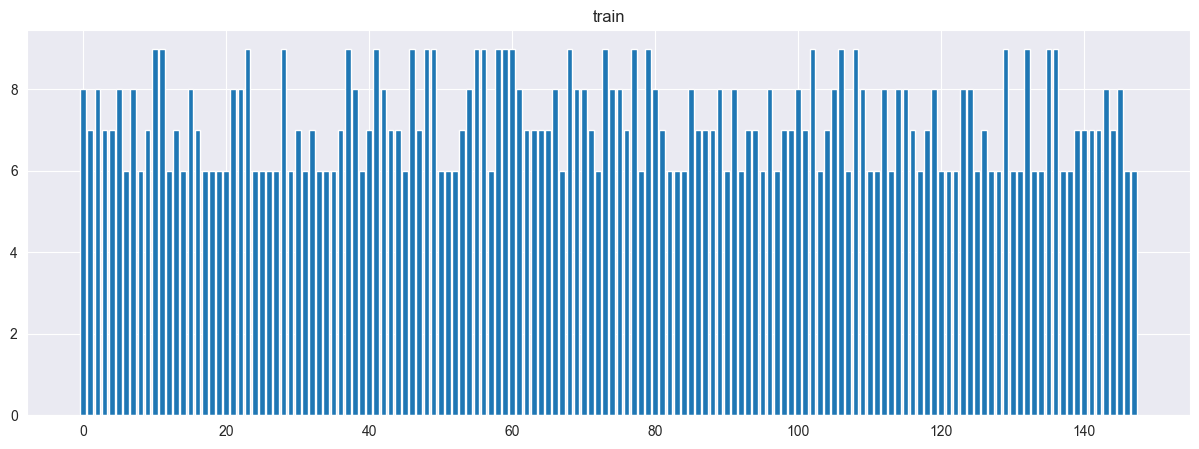

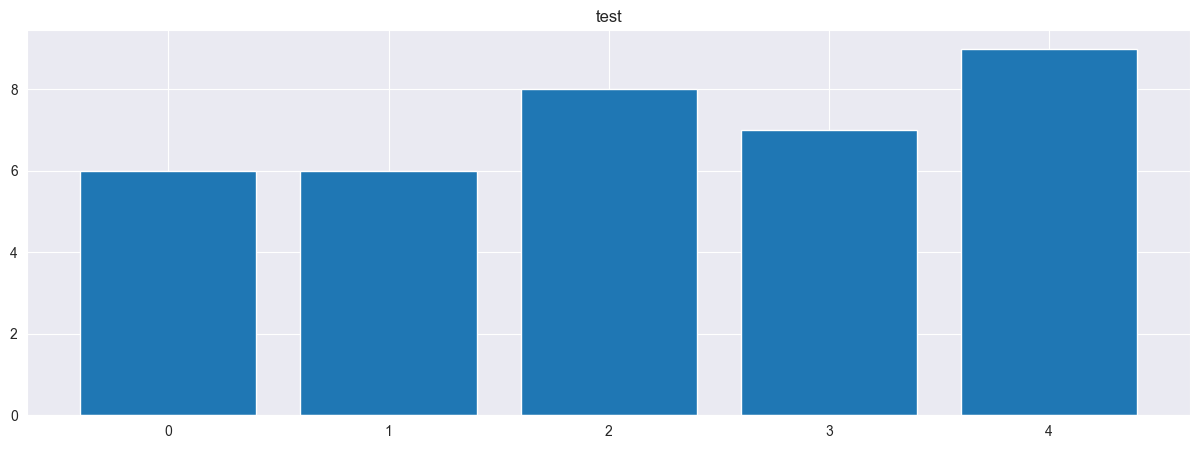

In [6]:
def show_class_distribtion(targets, title_text=None):
    if not isinstance(targets, list):
        targets = targets.tolist()
    # делаем данные (пары точек)
    classes_number = np.max(targets) + 1  # Максимальное знаечние класса. Думаем, что они нумеруются с 0
    bars = [targets.count(i) for i in range(classes_number)] # количество вхождений каждого класса
    
    fig, ax = plt.subplots(figsize=(15, 5))
    ax.bar(range(classes_number), bars)
    plt.title(title_text)
    plt.show()
    pass


show_class_distribtion(train_ds.targets, "train")
show_class_distribtion(test_ds.targets, "test")

##### [0 баллов] Задание 1.2. Датасет пар.

Как было сказано ранее, мы будем обучать модели предсказывать, разные ли люди изображены на фотографиях. Для этого нам надо научиться формировать пары фотографий и целевую переменную из двух классов: 0 и 1. \
Класс 0 означает, что это фотографии одного человека. \
Класс 1 означает фотографии разных людей. \
 \
К счастью, весь датасет уже написан.

In [7]:
class PairDataset(torch.utils.data.Dataset):
    def __init__(self, dataset):
        self.dataset = dataset
        self.targets = [ self._get_target(i) for i in tqdm.trange(len(self)) ]

    def _idx1(self, idx):
        return idx % len(self.dataset)
    
    def _idx2(self, idx):
        return idx // len(self.dataset)
    
    def _get_target(self, idx):
        return int(self.dataset.targets[self._idx1(idx)] != self.dataset.targets[self._idx2(idx)])

    def __len__(self):
        return len(self.dataset) ** 2

    def __getitem__(self, idx):
        image1, label1 = self.dataset[self._idx1(idx)]
        image2, label2 = self.dataset[self._idx2(idx)]
        return image1, image2, int(label1 != label2)
    
train_pairs = PairDataset(train_ds)
test_pairs = PairDataset(test_ds)

100%|██████████| 1296/1296 [00:00<?, ?it/s]


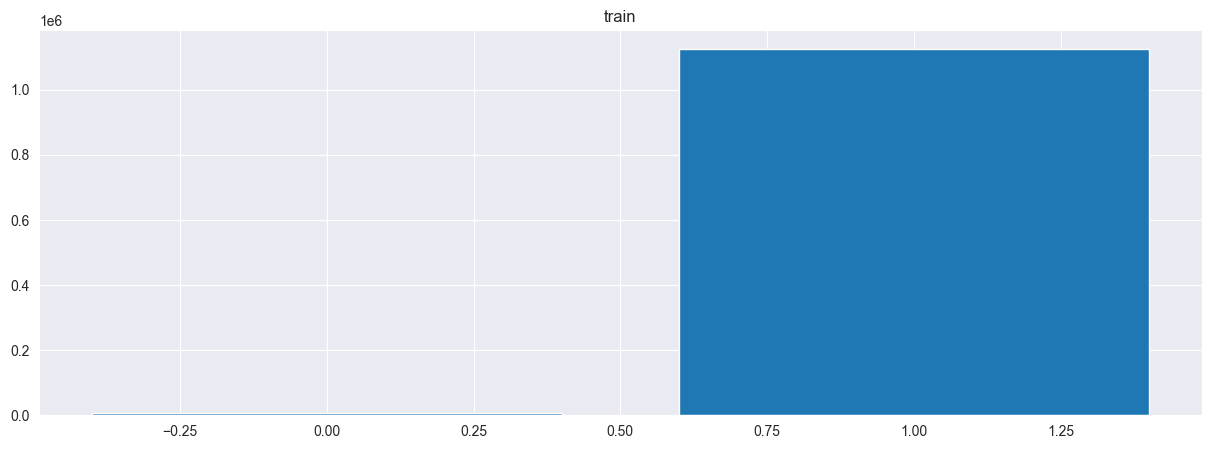

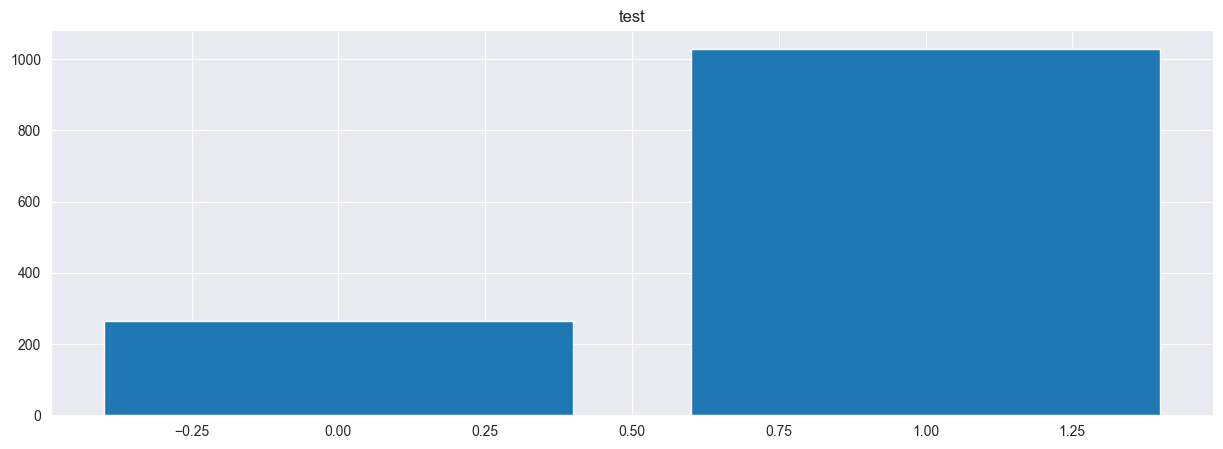

In [8]:
show_class_distribtion(train_pairs.targets, "train")
show_class_distribtion(test_pairs.targets, "test")

Легко видеть, что пар фотографий разных людей гораздо больше, чем пар фотографий одного человека. Это вполне ожидаемо, но, если не предпринять мер, ведет к двум проблемам:
1. Метрика качества предсказаний должна учитывать дисбаланс классов. В частности, accuracy нам не подойдёт. А использовать будем известный из курса машинного обучения AUC-ROC.
2. Нужно "подтюнить" даталоадер тренировочных данных, чтобы в каждый батч попадало примерно одинаковое количество фотографий каждого класса. Иначе победить деградацию модели к "всегда 1" будет очень сложно.

##### [1 балл] Задание 1.3. Стратифицированный даталоадер.

Для начала решим вторую проблему. Нужно сделать такой даталоадер, чтобы в каждом батче количество элементов класса "0" совпадало с количеством элементов класса "1".

Как известно, стандартный класс `DataLoader` в torch имеет много параметров. В частности, параметр `sampler` позволяет гибко управлять выдачей. Изучите [документацию](https://docs.pytorch.org/docs/stable/data.html#data-loading-order-and-sampler) и реализуйте свой семплер, который решит проблему.

В `pytorch_metric_learning` уже есть готовая реализация того, что нам нужно. Вы можете её найти и использовать. Но в таком случае __максимальный балл за это задание - 0.4__.

In [9]:
class MyStratifiedSampler(torch.utils.data.Sampler):
    def __init__(self, data: PairDataset) -> None:
        self.class1_idxes = np.array([i for i in range(len(data.targets)) if data.targets[i] == 1])
        self.class0_idxes = np.array([i for i in range(len(data.targets)) if data.targets[i] == 0])
        
        self.data = data
        self.batch_size = min(self.class0_idxes.shape[0], self.class1_idxes.shape[0])
        
        super(MyStratifiedSampler, self).__init__()

    def __len__(self) -> int:
        return self.batch_size * 2

    def __iter__(self) -> torch.utils.data.DataLoader:  # Dataloader - и есть итерат
        # Каждый раз перемешиваем все данные, чтобы не выкидывать одно и то же
        batch_part_0 = np.array(random.sample(self.class0_idxes.tolist(), k=self.batch_size))
        batch_part_1 = np.array(random.sample(self.class1_idxes.tolist(), k=self.batch_size))
        
        # Чтобы стратификация была ИДЕАЛЬНОЙ, будем чётко чередовать классы, тогда даже в маленьком семпле будет равномерность
        batch = []
        for i in range(self.batch_size):
            batch.append(batch_part_0[i])
            batch.append(batch_part_1[i])
        
        return iter(batch)
        
train_pairs_sampler = MyStratifiedSampler(train_pairs)

tensor([0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
        0, 1, 0, 1, 0, 1, 0, 1])


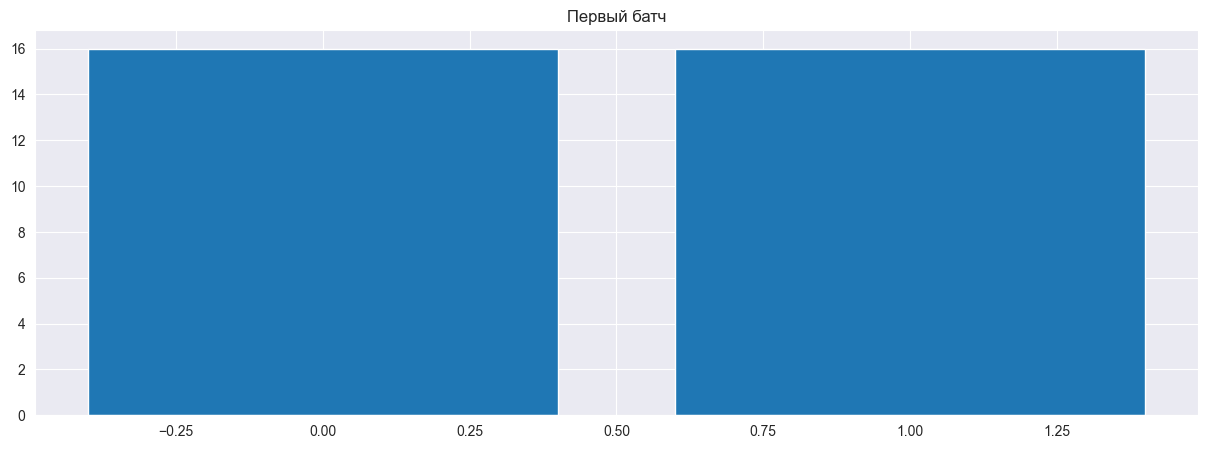

In [10]:
train_pairs_loader = torch.utils.data.DataLoader(train_pairs, batch_size = 32, sampler = train_pairs_sampler)
test_pairs_loader = torch.utils.data.DataLoader(test_pairs, batch_size = 64, shuffle = False)

# Убедимся, что теперь выдача равномерная.
print(next(iter(train_pairs_loader))[2])
show_class_distribtion(next(iter(train_pairs_loader))[2], "Первый батч")
# show_class_distribtion(next(iter(train_pairs_loader))[2], "Второй батч")
# show_class_distribtion(next(iter(train_pairs_loader))[2], "Третий батч")

### [3.5 балла] Часть 2. Классификация.

Начнём с простого: попробуем решить проблему как обычную задачу бинарной классификации. Реализуйте и обучите обычную свёрточную сеть, которая принимает два набора фотографий и предсказывает вероятность, что это фотографии разных людей.

##### [1 балл] Задание 2.1. Модель классификации.

Сначала нужно реализовать модель. В `forward` необходимо принять два батча фотографий. `i`-e число в выводе `forward` должно быть предсказанием для пары из `i`-й фотографии `image1` и `i`-й фотографии `image2`. Подумайте, как это сделать. Возможно, стоит как-нибудь склеить `image1` и `image2`? Или склеить эмбеддинги? А может быть нужен какой-то трешхолд?

Вы вольны использовать любую архитектуру сети. Ассерт в конце ячейки поможет вам убедиться, что модель теоретически делает то, что нужно.

In [11]:
from torch import nn

class ClassificationNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.encoder = nn.Sequential(
            
            # 3x250x250
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding='same'),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            # 16x250x250
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, stride=1, padding='same'),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2),
            # 16x125x125
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding='same'),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),
            # 32x62x62
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding='same'),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
            # 64x31x31
            nn.Conv2d(in_channels=64, out_channels=256, kernel_size=3, stride=1, padding='same'),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2),
            # 256x15x15
            nn.AdaptiveAvgPool2d((1, 1))
            # 256x1x1
        )
        
        self.head = nn.Sequential(
            nn.Flatten(),
            # in_features - 512, потому что мы склеили в forward две фичи длинной по 256 и получили одну в 512. Тут у меня ошибка была(
            nn.Linear(in_features=512, out_features=1000),
            nn.BatchNorm1d(1000),
            nn.ReLU(),
            nn.Linear(in_features=1000, out_features=1),
            nn.Sigmoid()
        )

    def forward(self, images_1_in_batch, images_2_in_batch):
        batch_size = images_1_in_batch.shape[0]
        # view в torch = reshape в numpy, параметр -1 означает, что мы автоматически подбираем размер без потери данных
        features_part_1 = self.encoder(images_1_in_batch).view(batch_size, -1)
        features_part_2 = self.encoder(images_2_in_batch).view(batch_size, -1)
        # склеиваем всё в один вектор
        # cat в torch = np.concatenate
        features = torch.cat((features_part_1, features_part_2), dim=1)
        logits = self.head(features)
        return logits.squeeze()
        

# Вы можете использовать этот ассерт в качестве теста, что ваша модель делает то, что нужно.
assert ClassificationNet()(*next(iter(train_pairs_loader))[:2]).shape == (32,)

##### [2 балла] Задание 2.2. Обучение.

Теперь обучите свою модель и добейтесь приемлемого качества. Балл за это задание вычисляется по формуле:

$$ clamp(0, 2.5 \cdot \dfrac{AucRoc - 0.6}{0.2}, 2.5) $$

То есть, для получения полного балла за это задание необходимо добиться AUC-ROC `0.8`

__При использовани предобученных моделей, балл за это задание умножается на 0.5__ (то есть, не более 1)

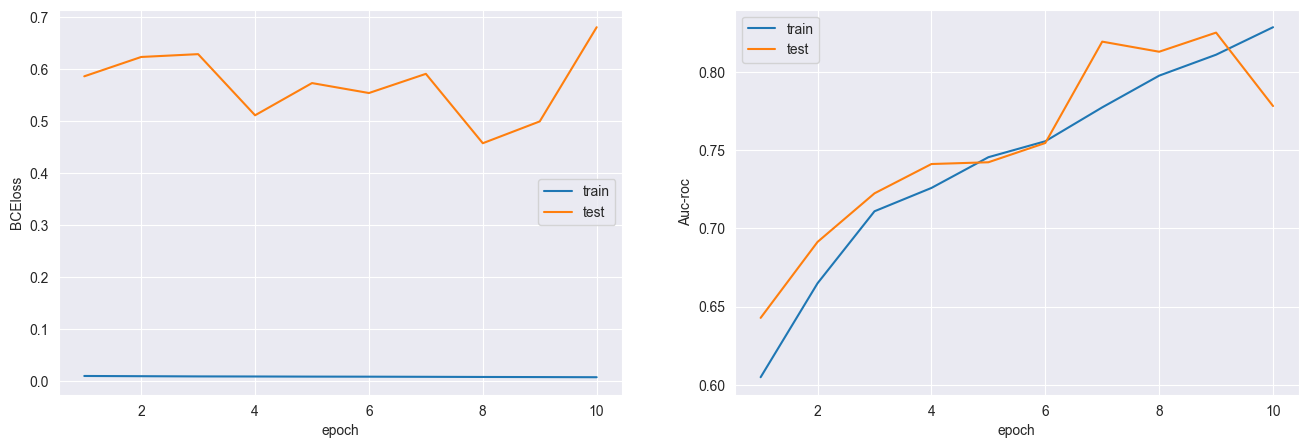

([0.009383682656964478,
  0.00895626874888518,
  0.008544740087783304,
  0.008386792522643483,
  0.008155264469232407,
  0.0080252600273227,
  0.007770101186888574,
  0.00747967799026384,
  0.007265962798699112,
  0.006985806778436898],
 [0.5864410150198289,
  0.6237032428199862,
  0.6291381812389986,
  0.5113996443925081,
  0.5734241950659105,
  0.5542690319779479,
  0.5911929945886871,
  0.45760406535348774,
  0.4995823348010028,
  0.6809835846041455],
 [np.float64(0.6049469922844649),
  np.float64(0.6649643311573202),
  np.float64(0.7109324945508362),
  np.float64(0.725825683429761),
  np.float64(0.7454545080638617),
  np.float64(0.7556446398528537),
  np.float64(0.7772950649548518),
  np.float64(0.7975433638047356),
  np.float64(0.8109191574565421),
  np.float64(0.8284701899279285)],
 [np.float64(0.6428461931527848),
  np.float64(0.6913643331630046),
  np.float64(0.7223811957077159),
  np.float64(0.7411033652091393),
  np.float64(0.7422293598072852),
  np.float64(0.7545331776042046

In [12]:
# Взял основу и структуру со своей первой домашки

from IPython.display import clear_output
from tqdm import tqdm
from sklearn.metrics import roc_auc_score

def plot_losses(train_losses, test_losses, train_auc_roc, test_auc_roc, ylabel_left = "loss", ylabel_right = "auc roc"):
    clear_output() # чтобы рисовать на том же месте, а не делать новый график
    fig, axs = plt.subplots(1, 2, figsize=(16, 5))
    
    axs[0].plot(range(1, len(train_losses) + 1), train_losses, label='train')
    axs[0].plot(range(1, len(test_losses) + 1), test_losses, label='test')
    axs[0].set_ylabel(ylabel_left)
    
    axs[0].set_xlabel('epoch')
    axs[0].legend()
    
    axs[1].plot(range(1, len(train_auc_roc) + 1), train_auc_roc, label='train')
    axs[1].plot(range(1, len(test_auc_roc) + 1), test_auc_roc, label='test')
    axs[1].set_ylabel(ylabel_right)

    axs[1].set_xlabel('epoch')
    axs[1].legend()

    plt.show()

def training_epoch(model, optimizer, criterion, train_loader, tqdm_desc):
    """Одна эпоха обучения
    params:
        model - torch.nn.Module to be fitted
        optimizer - model optimizer
        criterion - loss function from torch.nn
        train_loader - torch.utils.data.Dataloader with train set
        tqdm_desc - Prefix for the progressbar.
    """
    
    train_loss = 0.0
    all_train_predictions, all_labels = [], []
    model.train()  # переключение модели в режим тренировки
    for images_1_in_batch, images_2_in_batch, labels_in_batch in tqdm(train_loader, desc=tqdm_desc):
        # print(img1.shape, img2.shape, label.shape)
        # print(img1)
        # print(img2)
        # print(label)
        images_1_in_batch = images_1_in_batch.to(device)
        images_2_in_batch = images_2_in_batch.to(device)
        labels_in_batch = labels_in_batch.float().to(device)
        batch_size = images_1_in_batch.shape[0]
        
        # print(f'size(X) = {X.shape}, size(y) = {y.shape}')

        optimizer.zero_grad()
        logits = model(images_1_in_batch, images_2_in_batch)
        # print(f'size(logits) = {logits.shape}')
        loss = criterion(logits, labels_in_batch)
        # print(loss)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * batch_size
        
        predicts = logits.detach().cpu().numpy()
        all_train_predictions.extend(predicts)
        all_labels.extend(labels_in_batch.cpu().numpy().ravel())

    train_loss /= len(train_loader.dataset)
    train_auc_roc = roc_auc_score(all_labels, all_train_predictions)
    
    print(train_loss)
    print(train_auc_roc)
    return train_loss, train_auc_roc


@torch.no_grad()
def validation_epoch(model, criterion, val_loader, tqdm_desc):
    """Одна эпоха валидации модели
    params:
        model - torch.nn.Module to be fitted
        criterion - loss function from torch.nn
        val_loader - torch.utils.data.Dataloader with test set
                      (if you wish to validate during training)
    """
    val_loss = 0.0
    all_val_predictions, all_labels = [], []
    model.eval()
    for images_1_in_batch, images_2_in_batch, labels_in_batch in tqdm(val_loader, desc=tqdm_desc):
        images_1_in_batch = images_1_in_batch.to(device)
        images_2_in_batch = images_2_in_batch.to(device)
        labels_in_batch = labels_in_batch.float().to(device)
        batch_size = images_1_in_batch.shape[0]
        
        logits = model(images_1_in_batch, images_2_in_batch)
        loss = criterion(logits, labels_in_batch)
        val_loss += loss.item() * batch_size
        
        predicts = logits.detach().cpu().numpy()
        all_val_predictions.extend(predicts)
        all_labels.extend(labels_in_batch.cpu().numpy().ravel())

    val_loss /= len(val_loader.dataset)
    val_auc_roc = roc_auc_score(all_labels, all_val_predictions)
    return val_loss, val_auc_roc


def train(model, optimizer, criterion, train_loader, val_loader, epochs):
    """ Обучение модели
    params:
        model - torch.nn.Module to be fitted
        optimizer - model optimizer
        criterion - loss function from torch.nn
        train_loader - torch.utils.data.Dataloader with train set
        val_loader - torch.utils.data.Dataloader with test set
                      (if you wish to validate during training)
        epochs - number of training epochs
    """
    
    train_loss_history = []
    val_loss_history = []
    
    train_auc_roc_history = []
    val_auc_roc_history = []
    
    for epoch in range(1, epochs + 1):
        train_loss, train_auc_roc = training_epoch(model, optimizer, criterion, train_loader, tqdm_desc=f'Training {epoch}/{epochs}')
        val_loss, val_auc_roc = validation_epoch(model, criterion, val_loader, tqdm_desc=f'Validating {epoch}/{epochs}')

        train_loss_history.append(train_loss)
        val_loss_history.append(val_loss)
        
        train_auc_roc_history.append(train_auc_roc)
        val_auc_roc_history.append(val_auc_roc)

        plot_losses(train_loss_history, val_loss_history, train_auc_roc_history, val_auc_roc_history, "BCEloss", "Auc-roc")
    
    return train_loss_history, val_loss_history, train_auc_roc_history, val_auc_roc_history

set_random_seed(192)

NUM_EPOCHS = 10
LR = 0.0001

model = ClassificationNet().to(device)
criterion = nn.BCELoss()  # Binary Cross-Entropy
optimizer = torch.optim.AdamW(model.parameters(), lr=LR)

train(model, optimizer, criterion, train_pairs_loader, test_pairs_loader, NUM_EPOCHS)

In [13]:
def get_score(auc_roc):
    return max(0, min(2.5 * (auc_roc - 0.6) / 0.2, 2.5))

def get_auc_roc(your_model):
    preds = []
    targets = []
    your_model.eval()
    for images1, images2, labels in tqdm(test_pairs_loader):
        with torch.no_grad():
            output = your_model(images1.to(device), images2.to(device))
        preds.extend(output.detach().cpu().tolist())
        targets.extend(labels.detach().cpu().tolist())
    preds = numpy.array(preds)
    targets = numpy.array(targets)
    return sklearn.metrics.roc_auc_score(targets, preds)

get_score(get_auc_roc(model))

100%|██████████| 21/21 [00:04<00:00,  4.82it/s]


np.float64(2.2266223811957073)

##### [0.5 балла] Задание 2.3. Анализ и отчет.

Опишите свои эксперименты. Проанализируйте результаты. Почему результаты получились не очень хорошими? Может быть, решать задачу через бинарную классификацию - не лучшая идея? Приведите не менее 3 аргументов, почему это так.

Результаты не то, что бы супер-классные, но и не слабые, я считаю, что 0.85 на тесте - это приемлемо. Однако, можно улучшить!

Да, бинарная классификация тут не особо подходит, потому что при добавлении новых людей надо переобучать нейросеть (говорили на лекции) и качество в принципе хуже, нужно переходить на эмбеддинги (а то мы их просто склеивали... Было тупо, я даже сначал не понял, зачем. Надо было сравнивать эмбеддинги). Эмбеддинга также дадут некую интерпретацию модели (если постараться) и не нужно будет переобучать модель. Еще, BCELoss выглядит слабым, возможно, есть что-то сильнее. Я почитал про лоссы и понял, что помимо BCELoss есть ContrastiveLoss, TripletLoss, FocalLoss и др.

По итогу имеем такие аргументы:
- при добавлении новых людей надо переобучать нейросеть
- теряется смысл в эмбеддингах, когда мы их склеиваем
- низкое качество
- слабый loss

### [5 баллов] Часть 3. Распознавание лиц.

Теперь попробуем использовать более хитрые методы, которые лучше подходят для решаемой задачи. В частности, триплетную функцию потерь. Далее наша модель будет не предсказывать вероятность для двух картинок, а формировать эмбеддинги для одной картинки таким образом, чтобы эмбеддинги фотографий одного человека были близки, а разных людей - далеки.

##### [2 балла] Задание 3.1. Триплетная функция потерь.

Напомним теорию. Пусть $A$ - произвольное изображение; $P$ - изображение того же человека (позитивный пример); $N$ - изображение любого другого человека (негативный пример); $f$ - наша нейронная сеть; $\alpha$ - гиперпараметр, отвечающий за желаемый “отступ” – расстояние между латентными представлениями изображений разных людей. Тогда функционал ошибки определяется следующим образом:

$$ L(A, P, N) = max(||f(A) - f(P)|| - ||f(A) - f(N)|| + \alpha, 0) $$

В этом задании вам необходимо реализовать этот функционал. Для удобства в дальнейшем, предлагается сразу реализовать batch-версию. Таким образом, на входе должно быть 2 параметра:
- Набор эмбеддингов размера (batch_size, embedding_size)
- Набор классов (номера людей, чьи это фотографии) размера (batch_size)

Ваша функция должна найти все тройки $(A, P, N)$ и вычислить лосс для них.

В `pytorch_metric_learning` уже есть готовая реализация. Вы можете её найти и использовать. Но в таком случае __максимальный балл за это задание - 0.5__.

In [14]:
# Попробую сначала написать нормальный семплер под это дело
class TripletSampler(torch.utils.data.Sampler):
    def __init__(self, dataset, batch_size):
        self.dataset = dataset
        self.batch_size = batch_size
        self.targets = np.array(dataset.targets)
        self.classes = np.unique(self.targets)
        self.class_indices = {}  # Словарь: класс -> список индексов c этим классом
        for i in self.classes:
            self.class_indices[i] = np.where(self.targets == i)[0].tolist()
        self.triplets_per_class = max(1, batch_size // len(self.classes))
        super(TripletSampler, self).__init__(dataset)
        
    def __len__(self):
        return self.batch_size * 3  # ну тут очевидно)))
    
    def __iter__(self):
        triplets = []

        # Стараемся стратифицировать семплинг, берём якори из каждого класса
        for i in self.classes:
            class_indices = self.class_indices[i]
            if len(class_indices) < 2:  # Нужен хотя бы 1 anchor и 1 positive
                continue

            num_triplets = min(self.triplets_per_class, len(class_indices) // 2)
            anchor_indices = random.sample(class_indices, k=num_triplets)

            for anchor_idx in anchor_indices:
                # выбираем positive в триплете
                pos_candidates = [idx for idx in class_indices if idx != anchor_idx]  # не забываем отсекать случай, когда якорь равен pos
                if not pos_candidates:
                    continue
                pos_idx = random.choice(pos_candidates)
                
                # выбираем negative в триплете
                neg_class = random.choice([c for c in self.classes if c != i])
                neg_idx = random.choice(self.class_indices[neg_class])
                
                triplets.append((anchor_idx, pos_idx, neg_idx))

        # дополняем батч случайными тройками, если нужно
        while len(triplets) < self.batch_size:
            i = random.choice(self.classes)
            class_indices = self.class_indices[i]
            if len(class_indices) < 2:
                continue

            anchor_idx = random.choice(class_indices)
            pos_candidates = [idx for idx in class_indices if idx != anchor_idx]
            if not pos_candidates:
                continue
            pos_idx = random.choice(pos_candidates)
            neg_class = random.choice([c for c in self.classes if c != i])
            neg_idx = random.choice(self.class_indices[neg_class])

            triplets.append((anchor_idx, pos_idx, neg_idx))

        triplets = triplets[:self.batch_size]
        random.shuffle(triplets)

        # разворачиваем тройки в плоский список индексов
        flat_indices = []
        for anchor_idx, pos_idx, neg_idx in triplets:
            flat_indices.extend([anchor_idx, pos_idx, neg_idx])

        return iter(flat_indices)

In [15]:
class TripletLoss(nn.Module):
    def __init__(self, alpha=0.25):
        self.alpha = alpha
        super().__init__()
    
    def calculate_loss(self, anchor, positive, negative):
        distance_ap = torch.nn.functional.pairwise_distance(anchor, positive)
        distance_an = torch.nn.functional.pairwise_distance(anchor, negative)
        return max(0, (distance_ap - distance_an + self.alpha))
    
    def forward(self, embeddings, labels):
        batch_size = embeddings.shape[0]
        
        labels = labels.to(embeddings.device)
        labels_positive = labels.unsqueeze(1) == labels.unsqueeze(0)
        labels_negative = ~labels_positive
        
        total_loss = 0
        correct_triplets_count = 0
        
        for i in range(batch_size):
            labels_pos_backup = labels_positive.clone()
            labels_pos_backup[i][i] = False  # исключаем собственный индекс, чтобы использовались разные картинки
            indices_positive = torch.where(labels_pos_backup[i])[0]  # получили индексы с элементами, где у нас класс = 1 и это не сам элемент
            indices_negative = torch.where(labels_negative[i])[0]
            
            # Берем текущий элемент как якорь для триплетной функции
            anchor = embeddings[i]
            # Извлекаем эмбеддинги с нужными нам индексами
            embeddings_positive = embeddings[indices_positive]
            embeddings_negative = embeddings[indices_negative]
            # Считаем расстояния между векторами
            dists_positive = torch.nn.functional.pairwise_distance(anchor.unsqueeze(0), embeddings_positive).unsqueeze(1)
            dists_negative = torch.nn.functional.pairwise_distance(anchor.unsqueeze(0), embeddings_negative).unsqueeze(0)
            
            losses = dists_positive - dists_negative + self.alpha
            correct_triplets_indices = torch.where(losses > 0)[0]
            # Если есть хотя бы один нормальный триплет
            if correct_triplets_indices.any():
                total_loss += losses[correct_triplets_indices].sum()
                correct_triplets_count += correct_triplets_indices.sum()
        return total_loss / correct_triplets_count if correct_triplets_count > 0 else torch.tensor(0.0, device=embeddings.device)

criterion = TripletLoss()

In [16]:
# Вы можете использовать этот ассерт в качестве теста
embeddings = torch.tensor([
    [ 1., 2, 3 ],
    [ 1, 3, 4 ],
    [ 4, 5, 6 ]
])
labels = torch.tensor([ 1., 2, 1 ])
assert (criterion(embeddings, labels) - 2.6775) < 1e-4

##### [3 балла] Задание 3.2. Обучение.

Теперь обучите модель и добейтесь приемлемого качества. Балл за это задание вычисляется по формуле:

$$ clamp(0, 3 \cdot \dfrac{AucRoc - 0.8}{0.15}, 3) $$

То есть, для получения полного балла за это задание необходимо добиться AUC-ROC `0.95`

При необходимости, вы можете улучшить функцию потерь. Например, учитывать не все тройки, а только "сложные", как это умеет делать реализация в `pytorch_metric_learning`. Также подумайте над даталоадером. Возможно, имеет смысл брать в батч одинаковое количество фотографий каждого человека по аналгии с заданием 1.3? Тем не менее имейте в виду, что для получения полного балла за задание, вы должны реализовать все модификации самостоятельно, а не использовать готовые.

__При использовани предобученных моделей, балл за это задание умножается на 0.5__ (то есть, не более 1.5) \
__При использовани pytorch_metric_learning, балл за это задание уменьшается на 0.5 за каждое использование__

In [17]:
import torch.nn.functional as F

class NetWithTripletLoss(nn.Module):
    def __init__(self, embedding_size):
        super().__init__()
        self.embedding_size = embedding_size
        
        self.encoder = nn.Sequential(
            
            # 3x250x250
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding='same'),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            # 16x250x250
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, stride=1, padding='same'),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2),
            # 16x125x125
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding='same'),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),
            # 32x62x62
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding='same'),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
            # 64x31x31
            nn.Conv2d(in_channels=64, out_channels=256, kernel_size=3, stride=1, padding='same'),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2),
            # 256x15x15
            # nn.AdaptiveAvgPool2d((1, 1))
            # 256x1x1
        )
        
        self.head = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=256*15*15, out_features=512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(in_features=512, out_features=self.embedding_size)
        )

    def forward(self, image):
        encoded_image = self.encoder(image)
        embedding_for_image = self.head(encoded_image)
        return F.normalize(embedding_for_image, p=2, dim=1)

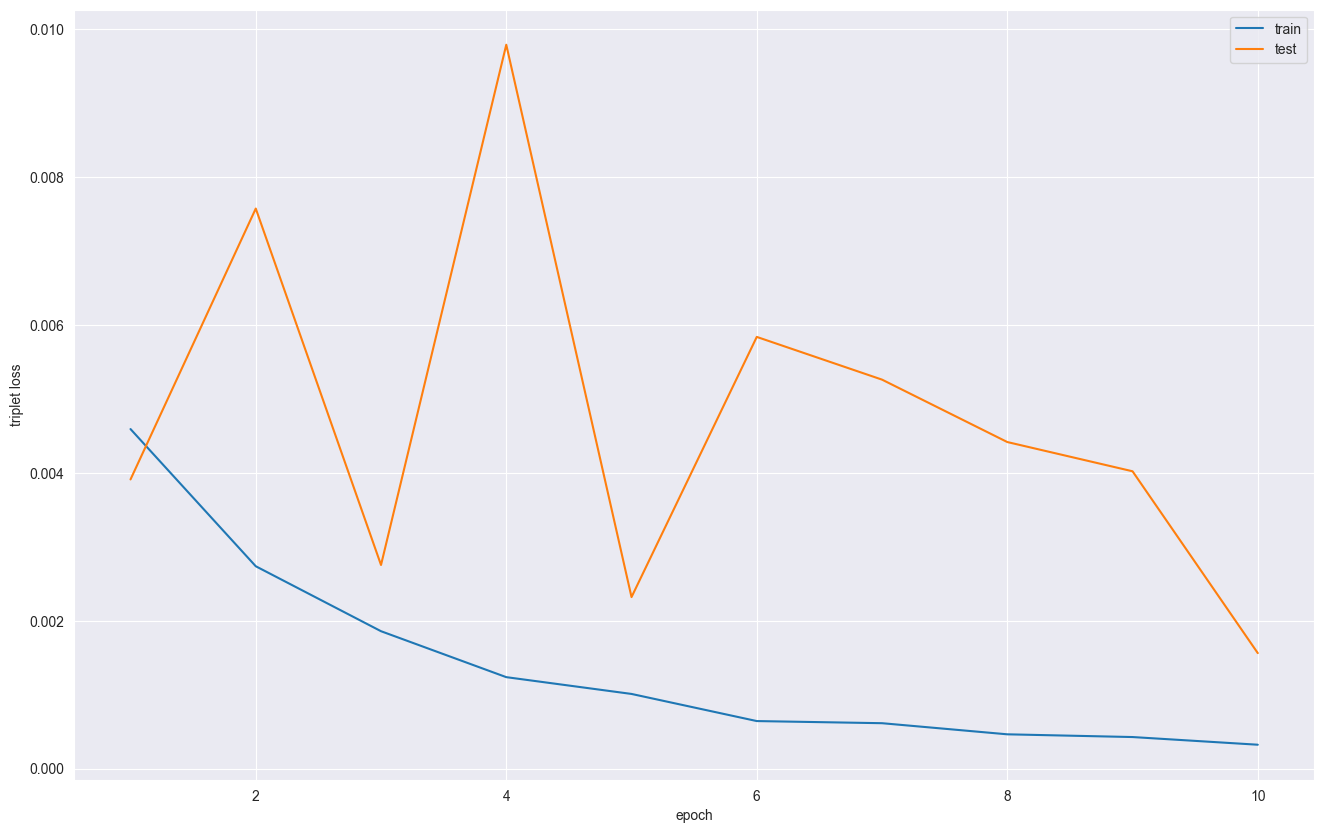

([0.0045931233136866575,
  0.0027374615271886188,
  0.001858852055151138,
  0.0012374593618330262,
  0.0010103820897463902,
  0.0006434953093808582,
  0.0006146191142744301,
  0.0004643101367592252,
  0.00042735322820188854,
  0.0003235195308678867],
 [0.003911711689498689,
  0.007575756145848168,
  0.002754734622107612,
  0.009791714035802417,
  0.0023205227529009185,
  0.00583952334192064,
  0.005261745924750964,
  0.00441759183175034,
  0.004022143367264006,
  0.0015626073711448247])

In [18]:
# короче говоря, мой семплер оказался мегаошибочным, поэтому я отчаялся и решил использовать готовый лосс(((((((( Для него нужен TripletDataset. Он похож на семплер, но немного другой, возвращает кортежи. С ним хотя бы работает, у меня нет времени семплер исправлять, полчаса до жесткого дд(((
class TripletDataset(torch.utils.data.Dataset):
    def __init__(self, base_dataset):
        self.base = base_dataset
        if hasattr(base_dataset, "targets"):
            targets = np.array(base_dataset.targets)
        elif hasattr(base_dataset, "labels"):
            targets = np.array(base_dataset.labels)
        else:
            targets = np.array([base_dataset[i][1] for i in range(len(base_dataset))])
        self.targets = targets
        self.classes = np.unique(self.targets)
        self.class_to_indices = dict()
        for i in self.classes:
            self.class_to_indices[i] = np.where(self.targets == i)[0].tolist()

    def __len__(self):
        return len(self.base)

    def __getitem__(self, idx):
        # ancor
        anchor_img, anchor_label = self.base[idx]

        # positive
        pos_candidates = self.class_to_indices[anchor_label]
        pos_idx = idx
        if len(pos_candidates) == 1:
            pos_idx = idx
        else:
            while pos_idx == idx:
                pos_idx = random.choice(pos_candidates)
        positive_img, _ = self.base[pos_idx]

        # negative
        neg_class = int(random.choice([c for c in self.classes if c != anchor_label]))
        neg_idx = random.choice(self.class_to_indices[neg_class])
        negative_img, _ = self.base[neg_idx]

        return anchor_img, positive_img, negative_img, anchor_label

def plot_losses(train_triplet_losses, test_triplet_losses):
    clear_output() # чтобы рисовать на том же месте, а не делать новый график
    fig, axs = plt.subplots(1, 1, figsize=(16, 10))
    
    axs.plot(range(1, len(train_triplet_losses) + 1), train_triplet_losses, label='train')
    axs.plot(range(1, len(test_triplet_losses) + 1), test_triplet_losses, label='test')
    axs.set_ylabel("triplet loss")
    
    axs.set_xlabel('epoch')
    axs.legend()
    
    plt.show()

def training_epoch(model, optimizer, criterion, train_loader, tqdm_desc):
    """Одна эпоха обучения
    params:
        model - torch.nn.Module to be fitted
        optimizer - model optimizer
        criterion - loss function from torch.nn
        train_loader - torch.utils.data.Dataloader with train set
        tqdm_desc - Prefix for the progressbar.
    """
    
    train_loss = 0.0
    model.train()  # переключение модели в режим тренировки
    for anchor, positive, negative, _label in tqdm(train_loader, desc=tqdm_desc):
        anchor = anchor.to(device)
        positive = positive.to(device)
        negative = negative.to(device)

        optimizer.zero_grad()
        embedding_a = model(anchor)
        embedding_p = model(positive)
        embedding_n = model(negative)

        loss = criterion(embedding_a, embedding_p, embedding_n)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(train_loader.dataset)
    return train_loss


@torch.no_grad()
def validation_epoch(model, criterion, val_loader, tqdm_desc):
    """Одна эпоха валидации модели
    params:
        model - torch.nn.Module to be fitted
        criterion - loss function from torch.nn
        val_loader - torch.utils.data.Dataloader with test set
                      (if you wish to validate during training)
    """
    val_loss = 0.0
    model.eval()
    for anchor, positive, negative, _label in tqdm(val_loader, desc=tqdm_desc):
        anchor = anchor.to(device)
        positive = positive.to(device)
        negative = negative.to(device)

        embedding_a = model(anchor)
        embedding_p = model(positive)
        embedding_n = model(negative)

        loss = criterion(embedding_a, embedding_p, embedding_n)
        val_loss += loss.item()

    val_loss /= len(val_loader.dataset)
    return val_loss


def train(model, optimizer, criterion, train_loader, val_loader, epochs):
    """ Обучение модели
    params:
        model - torch.nn.Module to be fitted
        optimizer - model optimizer
        criterion - loss function from torch.nn
        train_loader - torch.utils.data.Dataloader with train set
        val_loader - torch.utils.data.Dataloader with test set
                      (if you wish to validate during training)
        epochs - number of training epochs
    """
    
    train_loss_history = []
    val_loss_history = []
    
    
    for epoch in range(1, epochs + 1):
        train_loss = training_epoch(model, optimizer, criterion, train_loader, tqdm_desc=f'Training {epoch}/{epochs}')
        val_loss = validation_epoch(model, criterion, val_loader, tqdm_desc=f'Validating {epoch}/{epochs}')

        train_loss_history.append(train_loss)
        val_loss_history.append(val_loss)
        
        plot_losses(train_loss_history, val_loss_history)
    
    return train_loss_history, val_loss_history

set_random_seed(192)

NUM_EPOCHS = 10
LR = 0.0001
BATCH_SIZE = 32

model = NetWithTripletLoss(256).to(device)
criterion = nn.TripletMarginLoss(margin=0.2, p=2)
optimizer = torch.optim.AdamW(model.parameters(), lr=LR)
train_triplet_ds = TripletDataset(train_ds)
val_triplet_ds = TripletDataset(test_ds)
train_triplet_loader = torch.utils.data.DataLoader(train_triplet_ds, batch_size=BATCH_SIZE, shuffle=True)
test_triplet_loader = torch.utils.data.DataLoader(val_triplet_ds, batch_size=BATCH_SIZE, shuffle=False)

train(model, optimizer, criterion, train_triplet_loader, test_triplet_loader, NUM_EPOCHS)

In [19]:
def get_score(auc_roc):
    return max(0, min(3 * (auc_roc - 0.8) / 0.15, 3))

def get_auc_roc(your_model):
    preds = []
    targets = []
    your_model.eval()
    for images1, images2, labels in tqdm(test_pairs_loader):
        with torch.no_grad():
            emb1 = your_model(images1.to(device))
            emb2 = your_model(images2.to(device))
            # Вы можете изменить функцию расстояния между эмбеддингами, если считаете нужным
            dist = ((emb1 - emb2) ** 2).sum(dim = 1)
        preds.extend(dist.detach().cpu().tolist())
        targets.extend(labels.detach().cpu().tolist())
    preds = numpy.array(preds)
    targets = numpy.array(targets)
    return sklearn.metrics.roc_auc_score(targets, preds)

get_score(get_auc_roc(model))

100%|██████████| 21/21 [00:04<00:00,  4.70it/s]


np.float64(2.024965325936199)

##### [0.1 балла] Бонус: распознай себя

В качестве бонуса, загрузите свою фотографию (можно не одну), пропустите ее через модель и определите, на кого из известных людей, по мнению модели, вы больше всего похоже.

In [ ]:
# Я вас очень уважаю и люблю, дорогие проверяющие, но себя показывать мне стыдно после того, как я всё это написал и сдаю за полчаса до дд((( Извините